**Install dependencies**

In [ ]:
# %%capture
# !pip install -U torch torchvision torchaudio
# !pip install numpy pandas pillow gradio
# !pip install -U cjm_pil_utils cjm_kaggle_utils cjm_pytorch_utils

**Import dependencies**

In [ ]:
from pathlib import Path
import random

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm
import gradio as gr

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
from torchvision import transforms, models

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, get_torch_device

**Set device and data type**

In [ ]:
device = get_torch_device()
dtype = torch.float16 if device == 'cuda' else torch.float32
device, dtype

('cuda', torch.float16)

In [ ]:
dtype = torch.float32

**Enter Kaggle username and API token**

In [ ]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [ ]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Define directory paths**

In [ ]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Define Kaggle dataset**

In [ ]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /mnt/980_1TB_2/Datasets/hagrid-classification-512p-no-gesture-150k


**Download Kaggle dataset**

In [ ]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

Dataset already downloaded


**Get image classes**

In [ ]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

,0
0,call
1,dislike
2,fist
3,four
4,like
5,mute
6,no_gesture
7,ok
8,one
9,palm


**Get image paths**

In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

**Display sample image**

Class: ok


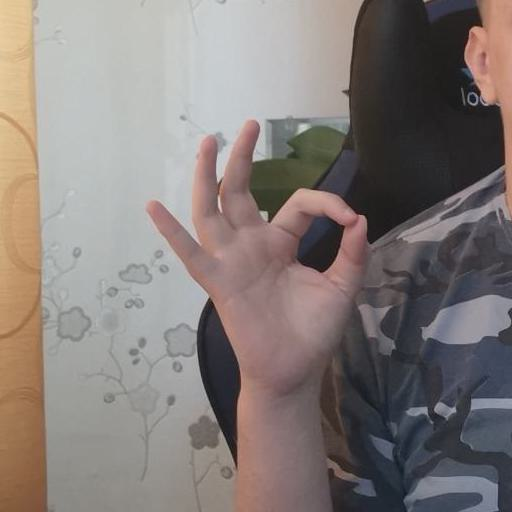

In [ ]:
# Select a random image path from the list of image paths
img_path = random.choice(img_paths)

# Print the name of the class of the image, which is the name of the parent folder
print(f"Class: {img_path.parent.name}")

# Open the image using the path
sample_img = Image.open(img_path)

# Display the image
sample_img

**Set training and validation sets**

In [ ]:
# img_paths_subset = random.sample(img_paths, 70000)
img_paths_subset = random.sample(img_paths, len(img_paths))

**List available ResNet18 models**

In [ ]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18
1,resnet18d


**Inspect config for ResNet18 model**

In [ ]:
# Import the convnext module
from timm.models import resnet

# Choose the resnet model
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(resnet.default_cfgs[resnet_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.875
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,conv1.0
classifier,fc


**Load ResNet18 model**

In [ ]:
# Load the resenet model
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type
resnet18 = resnet18.to(device=device, dtype=dtype).eval()
resnet18.device = device

**Select model**

In [ ]:
model = resnet18

**Set normalization stats**

In [ ]:
norm_stats = resnet.default_cfgs[resnet_model]['mean'], resnet.default_cfgs[resnet_model]['std']
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

**Set checkpoint directory**

In [ ]:
# Create a directory to store the checkpoints if it does not already exist
# checkpoint_dir = Path("./miniai_data_augmentation_seed-1/")
# checkpoint_dir = Path("./miniai_data_augmentation_seed-42/")
# checkpoint_dir = Path("./miniai_data_augmentation_seed-100/")
checkpoint_dir = Path("./miniai_data_augmentation_seed-1234/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Print the checkpoint path
checkpoint_dir

PosixPath('miniai_data_augmentation_seed-1234')

**Set checkpoint path**

In [ ]:
# checkpoint_path = checkpoint_dir/"resnet18d-baseline.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-rand-square-cp-1.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-rand-pixel-cp-1.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-rand-square-pixel-cp-1.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-trivial-aug-item-1.pth"
checkpoint_path = checkpoint_dir/"resnet18d-custom-trivial-aug-1.pth"
checkpoint_path

PosixPath('miniai_data_augmentation_seed-1234/resnet18d-custom-trivial-aug-1.pth')

**Load model checkpoint**

In [ ]:
model.load_state_dict(torch.load(checkpoint_path));

**Test model**

Class: stop_inverted
Predicted Class: stop_inverted


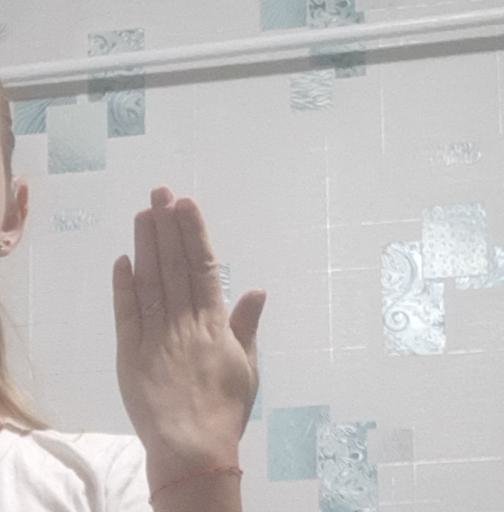

In [ ]:
# Choose a random image from the list of image paths
img_path = random.choice(img_paths)

# Print the actual class of the chosen image
print(f"Class: {img_path.parent.name}")

# Open the image and resize it
sample_img = Image.open(img_path)
inp_img = resize_img(sample_img.copy(), 288)

# Convert the image to a tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)

# Get the predicted class index and convert it to the class name
pred_class = class_names[torch.argmax(torch.sigmoid(pred))]

# Print the predicted class
print(f"Predicted Class: {pred_class}")

# Display the image
sample_img

**Perform inference on test set**

In [ ]:
# Initialize a list to store the file paths of the images that were incorrectly classified
wrong_imgs = []

# Iterate through the test image paths
for path in tqdm(img_paths_subset):
    # Get the actual class of the image
    target_cls = path.parent.name

    # Open and resize the image
    sample_img = Image.open(path)
    sample_img = resize_img(sample_img, 288)

    # Convert the image to a tensor and move it to the device
    img_tensor = pil_to_tensor(sample_img, *norm_stats).to(device=device, dtype=dtype)

    # Make a prediction with the model
    with torch.no_grad():
            pred = model(img_tensor)

    # Get the predicted class index and convert it to the class name
    pred_cls = class_names[torch.argmax(torch.sigmoid(pred))]
    
    # If the prediction is incorrect, add the file path to the list of wrong images
    if pred_cls != target_cls: wrong_imgs.append(path)

# Print the number of images that were incorrectly classified
len(wrong_imgs)

  0%|          | 0/153735 [00:00<?, ?it/s]

431

* seed 1: 
    * baseline: 505
    * rand-square-cp: 506
    * rand-pixel-cp: 577
    * rand-square-pixel-cp: 525
    * trivial-aug-item: 598
    * custom-trivial-aug: 526
* seed 42: 
    * baseline: 535
    * rand-square-cp: 465
    * rand-pixel-cp: 486
    * rand-square-pixel-cp: 440
    * trivial-aug-item: 571
    * custom-trivial-aug: 468
* seed 100: 
    * baseline: 602
    * rand-square-cp: 454
    * rand-pixel-cp: 478
    * rand-square-pixel-cp: 500
    * trivial-aug-item: 544
    * custom-trivial-aug: 478
* seed 1234: 
    * baseline: 467
    * rand-square-cp: 496
    * rand-pixel-cp: 539
    * rand-square-pixel-cp: 470
    * trivial-aug-item: 600
    * custom-trivial-aug: 431

**Inspect the number of wrong predictions per class**

In [ ]:
# Create a DataFrame from the list of incorrectly classified images
wrong_imgs_df = pd.DataFrame(wrong_imgs)

# Add a column to the DataFrame with the actual class of each image
wrong_imgs_df['class'] = wrong_imgs_df.apply(lambda row: Path(row[0]).parent.stem, axis=1)

# Create a DataFrame with the class distribution of the incorrectly classified images
class_dist_df = wrong_imgs_df['class'].value_counts().to_frame()

# Set the index name to "class"
class_dist_df.rename_axis("class", inplace=True)

# Display the class distribution DataFrame
class_dist_df

,class
class,
peace,47
three,44
no_gesture,35
palm,31
dislike,29
stop,27
four,25
two_up,25
one,24


**Set image paths for gradio interface**

In [ ]:
gr_img_paths = wrong_imgs
len(gr_img_paths)

431

**Initialize list of images to delete**

In [ ]:
marked_imgs = []

**Initialize list index**

In [ ]:
index = 0

**Define functions for gradio interface**

In [ ]:
def get_pred(img_path):
    """
    Get the prediction for a given image path using a pre-trained model.
    
    Parameters:
        img_path (Path): The path to the image.
        
    Returns:
        str: The predicted class label.
    """
    # Resize the image
    inp_img = resize_img(Image.open(img_path), 288)

    # Convert the image to a tensor and send it to the GPU
    img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device, dtype=dtype)

    # Use the model to make a prediction
    with torch.no_grad():
        pred = model(img_tensor)

    # Return the predicted class label
    return class_names[torch.argmax(torch.sigmoid(pred))]

def prev_image():
    """
    Go to the previous image in the list of images.
    
    Returns:
        Tuple: The path to the previous image, 
               the image class, the predicted class, and the value of the "Mark to Delete" button.
    """
    global index
    global marked_imgs
    # Decrement the index, or set it to the last image if we're already at the first image
    index = index - 1 if index > 0 else len(gr_img_paths)-1
    img_path = gr_img_paths[index]
    # Determine the value of the "Mark to Delete" button based on whether the image is in the list of marked images
    btn_val = "Unmark" if img_path in marked_imgs else "Mark to Delete"
    return gr_img_paths[index], gr_img_paths[index].parent.name, get_pred(img_path), btn_val

def next_image():
    """
    Go to the next image in the list of images.
    
    Returns:
        Tuple: The path to the next image, 
               the image class, the predicted class, and the value of the "Mark to Delete" button.
    """
    global index
    global marked_imgs
    # Increment the index, or set it to the first image if we're already at the last image
    index = index + 1 if index < len(gr_img_paths)-1 else 0
    img_path = gr_img_paths[index]
    # Determine the value of the "Mark to Delete" button based on whether the image is in the list of marked images
    btn_val = "Unmark" if img_path in marked_imgs else "Mark to Delete"
    return gr_img_paths[index], gr_img_paths[index].parent.name, get_pred(img_path), btn_val
    
def mark_to_delete():
    """
    Mark or unmark the current image for deletion.
    
    Returns:
        str: The new value of the "Mark to Delete" button, either "Mark to Delete" or "Unmark".
    """
    global index
    global marked_imgs
    # Get the path to the current image
    img_path = gr_img_paths[index]
    # If the image is in the list of marked images, remove it
    if img_path in marked_imgs: 
        marked_imgs.remove(img_path)
        return "Mark to Delete"
    # If the image is not in the list of marked images, add it
    else:
        marked_imgs.append(img_path)
        return "Unmark"

**Create gradio interface**

In [ ]:
with gr.Blocks() as demo:
    # Create a row for the previous and next buttons
    with gr.Row():
        prev_button = gr.Button('Previous')
        next_button = gr.Button('Next')
        
    # Create a row for the "Mark to Delete" button
    with gr.Row():
        mark_del_button = gr.Button('Mark to Delete')
        
    # Create a row for the text elements displaying the image class and predicted class
    with gr.Row():
        img_class_text = gr.Text(gr_img_paths[index].parent.name, label="Image Class")
        pred_class_text = gr.Text(get_pred(gr_img_paths[index]), label="Predicted Class")

    # Create an image output element
    image_output = gr.Image(gr_img_paths[index])

    # Set the behavior of the previous button
    prev_button.click(prev_image, outputs=[image_output, img_class_text, pred_class_text, mark_del_button])
    
    # Set the behavior of the next button
    next_button.click(next_image, outputs=[image_output, img_class_text, pred_class_text, mark_del_button])
    
    # Set the behavior of the "Mark to Delete" button
    mark_del_button.click(mark_to_delete, outputs=[mark_del_button])
        
# Launch the demo with a specified height
demo.launch(height=1600)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
index

0

In [ ]:
len(marked_imgs)

0

**Delete marked images**

In [ ]:
for path in marked_imgs:
    if path.exists():
        path.unlink()